# NLP Project

*Team members*:
- Asja Attanasio
- Daniele Laganà
- Marcello Martini
- Gianluigi Palmisano

# ⬇️ Import Dataset

Each record has three features:
- context
- question
- answer

In [1]:
! pip install itables plotly datamapplot bertopic

In [2]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Check if running in Kaggle
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if IN_KAGGLE:
  os.environ["TOKENIZERS_PARALLELISM"] = "false"
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

if IN_COLAB:
  !pip install datasets gensim==4.0.0 datamapplot

  Using cached gensim-4.0.0.tar.gz (23.1 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (gensim)


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import itables

# For interactive tables
itables.init_notebook_mode(all_interactive=False)



In [4]:
# Import dataset using the Hugging Face datasets library
dataset = load_dataset("neural-bridge/rag-dataset-12000")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 2400
    })
})

In [6]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [7]:
train_df.head()

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...


In [8]:
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Columns:", train_df.columns)

Train set size: 9600
Test set size: 2400
Columns: Index(['context', 'question', 'answer'], dtype='object')


# 🔎 Data exploration

In [9]:
# Count rows with at least one missing value in 'context', 'question', or 'answer'
missing_rows_train = train_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()
missing_rows_test = test_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()

print("Rows with at least one missing value in train set:", missing_rows_train)
print("Rows with at least one missing value in test set:", missing_rows_test)

# Remove null values
train_df = train_df.dropna()
test_df = test_df.dropna()

Rows with at least one missing value in train set: 2
Rows with at least one missing value in test set: 1


In [10]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize lists and variables for analysis
context_lengths = []
question_lengths = []
vocab = set()
all_tokens = []
train_df_tokenized = []

# Function to preprocess text
def preprocess(text):
    """Tokenize, lowercase, remove punctuation and stopwords from text."""
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]  # Keep only alphanumeric tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Function to process a single entry
def process_entry(entry):
    """Process a single dataset entry to extract tokens and update statistics."""
    context_tokens = preprocess(entry['context'])
    question_tokens = preprocess(entry['question'])

    # Update lengths
    context_lengths.append(len(context_tokens))
    question_lengths.append(len(question_tokens))
    answer_tokens = preprocess(entry['answer'])

    # Update vocabulary and token list
    vocab.update(context_tokens)
    vocab.update(question_tokens)
    all_tokens.extend(context_tokens)
    all_tokens.extend(question_tokens)
    train_df_tokenized.append({'context': context_tokens, 'question': question_tokens, 'answer': answer_tokens})

tqdm.pandas(desc="Processing entries")
train_df.progress_apply(process_entry, axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Processing entries: 100%|██████████| 9598/9598 [01:06<00:00, 143.31it/s]


,0
0,None
1,None
2,None
3,None
4,None
...,...
9595,None
9596,None
9597,None
9598,None


In [11]:
fdist = FreqDist(all_tokens)
fdist

FreqDist({'one': 14432, 'also': 10326, 'new': 10136, 'time': 10131, 'like': 9989, 'would': 8828, 'get': 8782, 'said': 7855, 'people': 7767, 'first': 6947, ...})

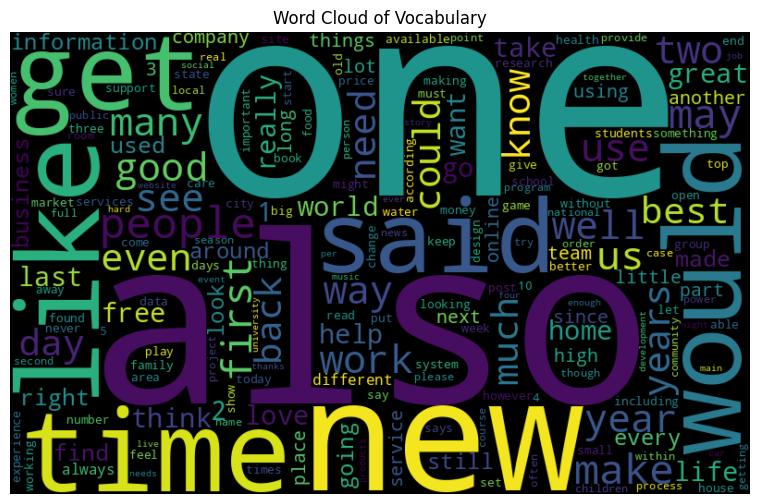

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(fdist)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Vocabulary")
plt.show()

<Axes: title={'center': 'Top 30 Most Frequent Words'}, xlabel='Samples', ylabel='Counts'>

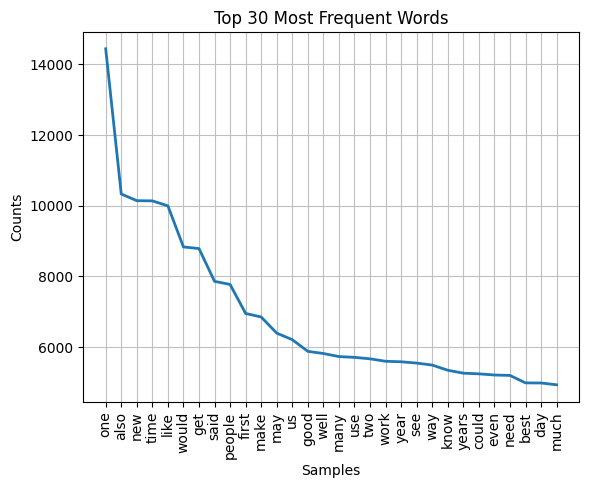

In [13]:
# Plotting the frequency distribution of the most common words
fdist.plot(30,  title="Top 30 Most Frequent Words")

Number of documents: 9598
Average context length: 321.12 tokens
Average question length: 6.81 tokens
Vocabulary size: 128313


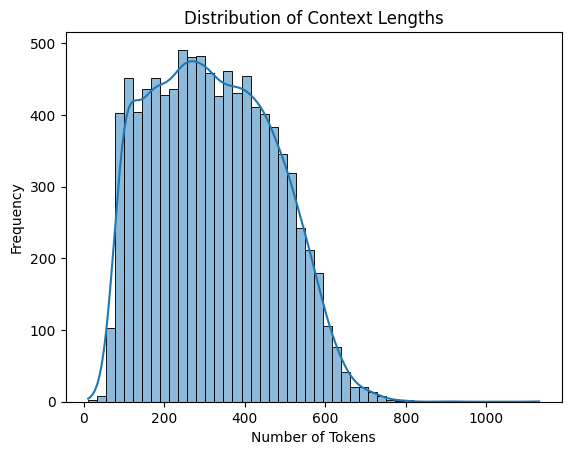

In [14]:
# Print statistics
print(f"Number of documents: {len(train_df)}")
print(f"Average context length: {sum(context_lengths)/len(context_lengths):.2f} tokens")
print(f"Average question length: {sum(question_lengths)/len(question_lengths):.2f} tokens")
print(f"Vocabulary size: {len(vocab)}")

# Plot distribution of context lengths
sns.histplot(context_lengths, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

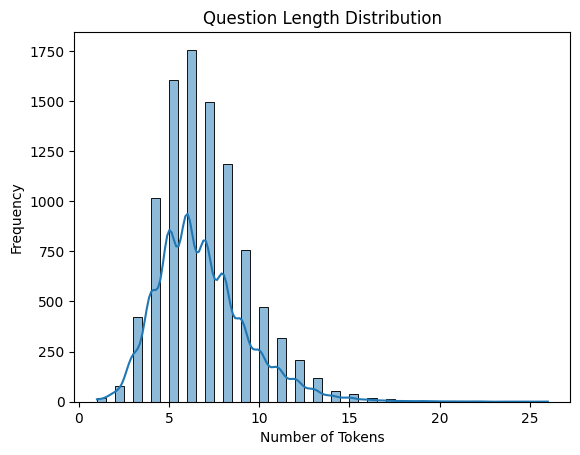

In [15]:
sns.histplot(question_lengths, bins=50, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

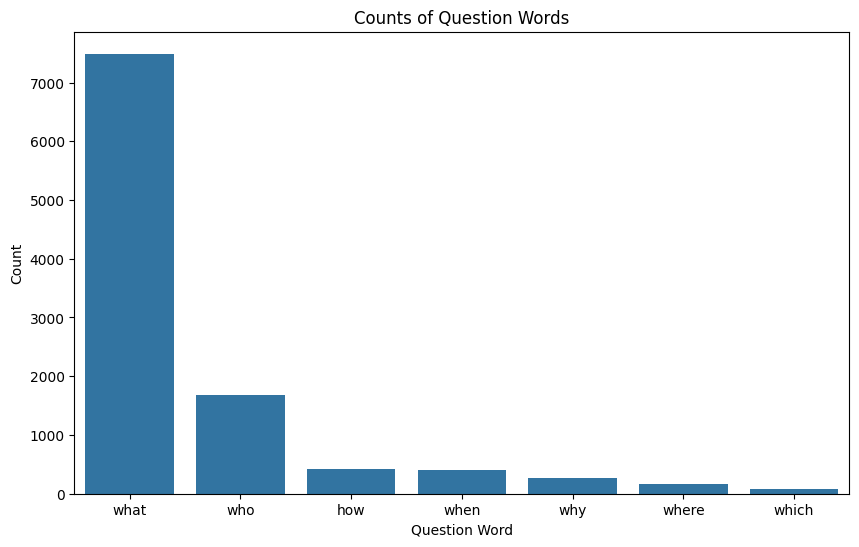

In [16]:
question_words = ["what", "where", "when", "why", "how", "who", "which"]
question_word_counts = {word: 0 for word in question_words}
for question in train_df['question']:
    tokens = word_tokenize(question.lower())
    for word in question_words:
        question_word_counts[word] += tokens.count(word)
question_word_counts
question_word_counts_df = pd.DataFrame(list(question_word_counts.items()), columns=['Question Word', 'Count'])
question_word_counts_df = question_word_counts_df.sort_values(by='Count', ascending=False)
# Plotting the counts of question words
plt.figure(figsize=(10, 6))
sns.barplot(x='Question Word', y='Count', data=question_word_counts_df)
plt.title('Counts of Question Words')
plt.ylabel('Count')
plt.show()

# 🧹 Data Cleaning

In [17]:
# first entry in train dataset as table without truncation
pd.set_option('display.max_colwidth', None)
train_df.head(1)

,context,question,answer
0,"Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption of protected substrate cropping, improved genetics and an expanding geographic footprint have all helped put Aussie berries on a positive trajectory.\n“We are seeing a real transition point. Broad industry interest and a strong commercial appetite for export market development combined with the potential to capitalise on existing trade agreements and build new trade partnerships has created this perfect environment for growth.”\nHigh-income countries across Europe, North America and Northern Asia have been identified as having a palate for Australian grown berries with more than 4244 tonnes of fresh berries exported in the last financial year alone.\nThe strategy identified the best short-term prospect markets for the Australian blackberry and raspberry industry as Hong Kong, Singapore, The United Arab Emirates and Canada. The strongest short-term trade options identified for the strawberry sector were Thailand, Malaysia, New Zealand and Macau.\nThe strategy focuses heavily on growing the existing strawberry export market from 4 per cent to at least 8 per cent of national production by volume, in markets with a capacity and willingness to pay a premium for quality fruit. For raspberries and blackberries, the sectors aim to achieve a 5 per cent boost in exports assessed by volume across identified markets by 2021.\nTasmanian raspberry exporter Nic Hansen said Australia offers some of the sweetest and most attractive berries in the world, and this combined with our stringent food safety standards across all stages of the supply chain puts growers in a solid position.\n“We have a great product, we are hungry to expand trade and now with this new plan in place, we have a clear roadmap towards driving growth,” Mr Hansen said.\nHe said it is exciting to see new export market prospects for raspberries: “The more options we have for export the better. Now we just have to get on with the job of ensuring industry has all the tools it needs, such as supporting data and relationship building opportunities, to thrive in new markets.”\nThis project was commissioned by Hort Innovation, and developed by market analysts and research consultants Auspex Strategic Advisory and AgInfinity. Hort Innovation will work now with berry sectors to determine levy-funded activities to support trade.\nSee a summary of the strategy on the Hort Innovation website.\nFor more information on the berry industries, refer to the Horticulture Statistics Handbook and the Strategic Investment Plans for strawberries, raspberries and blackberries. Growers seeking more information should email trade@horticulture.com.au",What is the Berry Export Summary 2028 and what is its purpose?,"The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors’ current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over t

In [18]:
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text, preserve_question_words=False):
    """
    Clean and preprocess text by removing punctuation, stopwords, and optionally preserving question words.
    """
    # Define question words to preserve
    question_words = {"what", "where", "when", "why", "how", "who", "which"}

    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Lemmatize, remove punctuation, and stopwords
    if preserve_question_words:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and (word not in stop_words or word in question_words)]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Initialize tqdm for pandas to show progress
tqdm.pandas(desc="Cleaning Text")
# Clean the training set
train_df['context'] = train_df['context'].progress_apply(lambda x: clean_text(x))
train_df['question'] = train_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
train_df['answer'] = train_df['answer'].progress_apply(lambda x: clean_text(x))
# Clean the test set
test_df['context'] = test_df['context'].progress_apply(lambda x: clean_text(x))
test_df['question'] = test_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
test_df['answer'] = test_df['answer'].progress_apply(lambda x: clean_text(x))

Cleaning Text:   0%|          | 0/9598 [00:00<?, ?it/s]

In [ ]:
train_df.head(1)

# 💬 Word Embedding (Word2Vec - questions)

In [ ]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

# Tokenize the questions into words
train_df['tokenized_question'] = train_df['question'].apply(lambda x: word_tokenize(x.lower()))

vector_size = 5 # Size of the word vectors

# Train the Word2Vec model with optimized parameters for better embedding quality
word2vec_model = Word2Vec(
    sentences=train_df['tokenized_question'],
    vector_size=vector_size,
    window=10,  # Increase the context window size
    min_count=2,  # Ignore words that appear less frequently
    workers=4,
    sg=1,  # Use skip-gram model for better performance on smaller datasets
    hs=0,  # Use negative sampling
    negative=10,  # Number of negative samples
    epochs=20  # Train for more epochs
)


In [ ]:
# Function to get the average word embedding for a question
def get_average_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are found
    return np.mean(vectors, axis=0)

# Generate sentence embeddings for the questions
train_df['question_embedding'] = train_df['tokenized_question'].apply(lambda x: get_average_embedding(x, word2vec_model))

# Stack embeddings into a matrix
question_embeddings = np.stack(train_df['question_embedding'].values)
question_embeddings.shape

In [ ]:
from sklearn.metrics import silhouette_score

# Function to find the optimal number of clusters using the Elbow Method and Silhouette Analysis
def find_optimal_clusters(embeddings, max_clusters=10):
    wcss = []  # Within-Cluster Sum of Squares
    bss = []  # Between-Cluster Sum of Squares
    silhouette_scores = []  # Silhouette Scores
    cluster_range = range(2, max_clusters + 1)

    # Calculate Total Sum of Squares (TSS)
    tss = np.sum((embeddings - np.mean(embeddings, axis=0))**2)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)

        # Calculate WCSS
        wcss.append(kmeans.inertia_)

        # Calculate BSS
        bss.append(tss - kmeans.inertia_)

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # Plot Elbow Method for WCSS and BSS
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, wcss, marker='o', label='WCSS (Within-Cluster Sum of Squares)')
    plt.plot(cluster_range, bss, marker='o', label='BSS (Between-Cluster Sum of Squares)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squares')
    plt.title('Elbow Method for Optimal Clusters')
    plt.legend()
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
    # Plot the cluster number above each point
    for i, score in enumerate(silhouette_scores):
        plt.text(cluster_range[i], score, str(cluster_range[i]), fontsize=9, ha='center')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal Clusters')
    plt.legend()
    plt.show()

    return wcss, bss, silhouette_scores

# Find the optimal number of clusters
wcss, bss, silhouette_scores = find_optimal_clusters(question_embeddings, max_clusters=25)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

n_clusters = 4

# Perform K-Means clustering with 7 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_df['cluster'] = kmeans.fit_predict(question_embeddings)

# Reduce dimensions of question embeddings using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
question_embeddings_2d = tsne.fit_transform(question_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(question_embeddings_2d[:, 0], question_embeddings_2d[:, 1], c=train_df['cluster'], cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title(f't-SNE Visualization of Question Clusters ({n_clusters} Clusters)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Function to extract topics for each cluster
def get_cluster_topics(df, cluster_col, text_col, top_n=10):
    cluster_topics = {}
    for cluster_id, group in df.groupby(cluster_col):
        # Tokenize all questions in the cluster
        all_words = [word for question in group[text_col] for word in word_tokenize(question.lower())]
        # Count word frequencies
        word_freq = Counter(all_words)
        # Get the top N most common words
        cluster_topics[cluster_id] = word_freq.most_common(top_n)
    return cluster_topics

# Get topics for each cluster
topics = get_cluster_topics(train_df, cluster_col='cluster', text_col='question', top_n=10)

# Display topics for each cluster
for cluster_id, words in topics.items():
    print(f"Cluster {cluster_id}:")
    print(", ".join([f"{word} ({count})" for word, count in words]))
    print("\n")

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
# Reduce dimensions of question embeddings to 3D using PCA
pca = PCA(n_components=3)
question_embeddings_3d = pca.fit_transform(question_embeddings)


# Prepare a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PCA Dimension 1': question_embeddings_3d[:, 0],
    'PCA Dimension 2': question_embeddings_3d[:, 1],
    'PCA Dimension 3': question_embeddings_3d[:, 2],
    'Cluster': train_df['cluster'],
    'Question': train_df['question']
})
# Create an interactive 3D scatter plot with a larger figure size
fig = px.scatter_3d(
    visualization_df,
    x='PCA Dimension 1',
    y='PCA Dimension 2',
    z='PCA Dimension 3',
    color='Cluster',
    hover_data=['Question'],  # Show the question on hover
    title='Interactive 3D Visualization of Question Clusters',
    width=1200,  # Set the width of the plot
    height=1000   # Set the height of the plot
)

# Show the plot
fig.show()

# 🔠 TF-IDF analysis

In [ ]:
# Convert the list of tokenized dictionaries into a DataFrame
train_df_tokenized = pd.DataFrame(train_df_tokenized, columns=['context', 'question', 'answer'])

train_df_tokenized.head(1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized lists back into strings for TF-IDF processing because TfidfVectorizer expects text input as strings
train_df_tokenized['context_str'] = train_df_tokenized['context'].apply(lambda tokens: ' '.join(tokens))
train_df_tokenized['question_str'] = train_df_tokenized['question'].apply(lambda tokens: ' '.join(tokens))

# Option 1: Apply TF-IDF on the 'context' field to compute the term frequency-inverse document frequency for words in the 'context' field
vectorizer_context = TfidfVectorizer()
tfidf_context = vectorizer_context.fit_transform(train_df_tokenized['context_str'])

# Option 2: Apply TF-IDF on the 'question' field to compute the term frequency-inverse document frequency for words in the 'question' field
vectorizer_question = TfidfVectorizer()
tfidf_question = vectorizer_question.fit_transform(train_df_tokenized['question_str'])

# Option 3: Apply TF-IDF on the combined 'context' and 'question' fields
train_df_tokenized['combined'] = train_df_tokenized['context_str'] + ' ' + train_df_tokenized['question_str']

# This vectorizer will compute the term frequency-inverse document frequency for words in the combined field
vectorizer_combined = TfidfVectorizer()
tfidf_combined = vectorizer_combined.fit_transform(train_df_tokenized['combined'])

In [ ]:
# Convert the sparse matrix of TF-IDF values for 'context' into a pandas DataFrame

tfidf_context_df = pd.DataFrame(tfidf_context.toarray(), columns=vectorizer_context.get_feature_names_out())
tfidf_question_df = pd.DataFrame(tfidf_question.toarray(), columns=vectorizer_question.get_feature_names_out())
tfidf_combined_df = pd.DataFrame(tfidf_combined.toarray(), columns=vectorizer_combined.get_feature_names_out())

print("Shape of TF-IDF Context DataFrame:", tfidf_context_df.shape)
print("Shape of TF-IDF Question DataFrame:", tfidf_question_df.shape)
print("Shape of TF-IDF Combined DataFrame:", tfidf_combined_df.shape)

In [ ]:
word_scores = tfidf_context_df.sum(axis=0).sort_values(ascending=False)

# Plot top 20 words by TF-IDF score
top_n = 20
top_words = word_scores.head(top_n)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20.colors  # Use a colormap for different colors
top_words.plot(kind='bar', color=[colors[i % len(colors)] for i in range(len(top_words))])
plt.title(f"Top {top_n} Words by TF-IDF Score")
plt.xlabel("Words")
plt.ylabel("Total TF-IDF Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Add a column to the DataFrame with the top N words for each document
feature_names = vectorizer_context.get_feature_names_out()

# Function to get top N words for a single document
def get_top_n_words(row, n):
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[::-1][:n]

    return [(feature_names[i], row_data[i]) for i in top_indices if row_data[i] > 0]


# Apply the function to each row of the TF-IDF DataFrame
N = 5 # Number of top words to extract
#Next to the word there is also the tfidf score
train_df_tokenized[f'top_{N}_tfidf_words_context'] = [
    get_top_n_words(tfidf_context[i], N) for i in range(tfidf_context.shape[0])
]

In [ ]:
train_df_tokenized.tail(1)

In [ ]:
from matplotlib.colors import to_hex
import random
import re
from IPython.display import display, HTML

def highlight_words_in_text_colored(text, words_to_highlight, colors):
    """
    Highlight specific words in a given text with corresponding colors.
    """
    for (word, _), color in zip(words_to_highlight, colors):
        # Use regex to match whole words only
        text = re.sub(rf'\b{re.escape(word)}\b', f"<mark style='background-color:{color};'>{word}</mark>", text)
    return text

def plot_and_highlight_document_colored(doc_index, title='Top TF-IDF Words'):
    """
    Plot top TF-IDF words with different colors and highlight them in the document with the same colors.
    """
    word_score_pairs = train_df_tokenized.loc[doc_index, f'top_{N}_tfidf_words_context']
    words, scores = zip(*word_score_pairs)

    # Generate unique colors for each word
    colors = [to_hex(plt.cm.tab10(i % 10)) for i in range(len(words))]

    # Plot top TF-IDF words with different colors
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.barh(words[::-1], scores[::-1], color=colors[::-1])  # reverse for descending order
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.tight_layout()

    # Highlight words in the document with the same colors
    highlighted_text = highlight_words_in_text_colored(train_df_tokenized.loc[doc_index, 'context_str'], word_score_pairs, colors)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    display(HTML(f"<div style='font-size:14px; line-height:1.6;'>{highlighted_text}</div>"))
    plt.show()

# Example: visualize the first 5 documents

documents_to_show = 3
for i in range(3):
    plot_and_highlight_document_colored(i, title=f'Document {i+1} - Top TF-IDF Words')

# 🗂️ Dataset indexing & searching

In [ ]:
from gensim import corpora, models, similarities

# Create the dictionary and corpus for the TF-IDF model
texts = train_df['context']
texts = [word_tokenize(text.lower()) for text in texts]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build the TF-IDF vectorizer
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# Create the similarity index
index = similarities.MatrixSimilarity(corpus_tfidf)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

# Function to get the most similar documents
def search(query_tokens, top_k=3):
    query_bow = dictionary.doc2bow(query_tokens)
    query_tfidf = tfidf_model[query_bow]
    sims = index[query_tfidf]  # cosine similarities
    top_indices = sorted(enumerate(sims), key=lambda x: -x[1])[:top_k]
    results = train_df.iloc[[i for i, _ in top_indices]].copy()
    results['similarity'] = [score for _, score in top_indices]
    return results[['context', 'question', 'answer', 'similarity']]

# Create an output widget for displaying the results
output_area = widgets.Output()

# Function to handle search queries
def interactive_search(change):
    query = change['new']
    query_tokens = preprocess(query)  # Tokenize and preprocess the query
    result_df = search(query_tokens)
    with output_area:
        clear_output(wait=True)  # Clear only the output area
        output_area.append_display_data(result_df)  # Append the resulting dataframe to the output area

# Create a text input widget
search_bar = widgets.Text(
    value='',
    placeholder='Enter your search query',
    description='Search:',
    layout=widgets.Layout(width='50%')
)

# Add an observer to the search bar
search_bar.observe(interactive_search, names='value')

# Display the search bar and output area
display(search_bar, output_area)

# 📝 Sentence embedding (all-MiniLM-L6-v2 on context)

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings.
model = SentenceTransformer('all-MiniLM-L6-v2')

sentence_embeddings = model.encode(train_df['context'].tolist(), convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# Perform community detection on the sentence embeddings
clusters = util.community_detection(sentence_embeddings, min_community_size=10, threshold=0.6, show_progress_bar=True)

print("Number of clusters found:", len(clusters))
cluster_sizes = [len(cluster) for cluster in clusters]
print("Cluster coverage:", sum(cluster_sizes) / len(train_df))

# Plot the distribution of cluster sizes
plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes, kde=True)
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Print all clusters with the members
# for i, cluster in enumerate(clusters):
#     print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
#     for sentence_id in cluster:
#         print("\t", train_df['context'].iloc[sentence_id])

# 🎩 Topic Modelling (BERTopic)

In [ ]:
from bertopic import BERTopic

# Create a BERTopic model
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(train_df['context'].tolist())

In [ ]:
print("Number of topics found:", len(topic_model.get_topic_info()))
# Display the topics
topic_model.get_topic_info()

In [ ]:
# Visualize the topics
topic_model.visualize_topics()

In [ ]:
# visualize the document representation
topic_model.visualize_documents(train_df['context'].tolist(), topics = list(range(20)), hide_document_hover=True)

In [ ]:
# Due to incompatibility with the current environment, we will not visualize the document datamap if using Kaggle
if not IN_KAGGLE:
  # Visualize the document datamap
  topic_model.visualize_document_datamap(train_df['context'].tolist(), interactive=True, enable_search=True)

In [ ]:
# visualize the topic representation
topic_model.visualize_barchart(top_n_topics=40)

In [ ]:
topic_no = 27

print(f"Topic {topic_no}:")
# get the topic representation
for topic, prob in topic_model.get_topic(topic_no):
    print(f"{topic}: {prob:.2f}")
# find all the documents in a topic and relative topics in a pretty format
for i in topic_model.get_representative_docs(topic_no):

    index = train_df[train_df['context'].str.contains(i)].index[0]
    print(f'Document {index}\nContext: {i}')
    # find the record in the original dataset by a serach on the context and print question and answer
    print("Question:", train_df[train_df['context'].str.contains(i)]['question'].values[0])
    print("Answer:", train_df[train_df['context'].str.contains(i)]['answer'].values[0])

In [ ]:
# sviualize the word topics without the document representation
topic_model.visualize_heatmap(top_n_topics=50)

## Hierarchical clustering on topics

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(train_df['context'].tolist())

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
itables.show(hierarchical_topics.sort_values(by='Distance', ascending=False), max_rows=1000)

# 🔮 Microsoft phi-2 LLM model QA ability testing

In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
print(f"Transformers version: {transformers.__version__}")

In [ ]:
if IN_KAGGLE or IN_COLAB:
    torch.set_default_device("cuda")

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

tokenizer.pad_token = tokenizer.eos_token

print(model.device)

In [ ]:
model.to("cuda")

In [ ]:
n_test = 5

train_df = dataset['train'].to_pandas()

subset = train_df.sample(n_test, random_state=42)

In [ ]:
def store_answer(entry, generation_function, context=False):
    question = entry['question']
    context = entry['context']
    if context:
        answer = generation_function(question, context)
    else:
        answer = generation_function(question)
    return answer

## Zero shot

In [ ]:
def generate_answer_zeroshot(entry):
    question = entry['question']
    prompt = f'''
        You are an assistant designed to answer questions.
        The question will be provided at the end of the prompt.
        Just answer the question concisely without any further text.
        Question: {question}
        '''
    inputs = tokenizer(question, return_tensors="pt", padding=True).to("cuda")
    outputs = model.generate(
    **inputs,
    max_new_tokens=50,
    pad_token_id=tokenizer.eos_token_id
    )
    text = tokenizer.batch_decode(outputs)[0]
    return text

In [ ]:
tqdm.pandas(desc="Generating answers using zero-shot phi-2")
subset['zeroShot_answer'] = subset.progress_apply(generate_answer_zeroshot, axis=1)

In [ ]:
subset[['question', 'answer', 'zeroShot_answer']].head(n_test)
# Save the subset with generated answers to a CSV file
subset.to_csv('subset_with_generated_answers.csv', index=True)

In [ ]:
def generate_answer_zeroshot_context(question, context):
    prompt = f'''
        You are an assistant designed to answer questions.
        The context and question will be provided below.
        Use the context to answer the question concisely without any further text.
        Context: {context}
        Question: {question}
        '''
    inputs = tokenizer(
        question,
        return_tensors="pt",
        return_attention_mask=False
    )
    outputs = model.generate(**inputs, max_length=1024)
    text = tokenizer.batch_decode(outputs)[0]
    return text

In [ ]:
tqdm.pandas(desc="Generating answers using zero-shot with context phi-2")
subset['zeroShot_context_answer'] = subset.progress_apply(
    lambda row: store_answer(row, generate_answer_zeroshot_context, context=True),
    axis=1
)

In [ ]:
subset[['question', 'answer', 'zeroShot_answer', 'zeroShot_context_answer']].head(n_test)


In [ ]:
subset.to_csv('subset_with_generated_answers_with_context.csv', index=False)